<a href="https://colab.research.google.com/github/JDS289/DNNs/blob/main/DeepNN_2025_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks - First Assignment 2025
## Ferenc Huszár and Nic Lane
### Due date: 21 February, 2025


#Info


Welcome to the first assignment for the Deep Learning and Neural Networks (DeepNN) module. This first half is marked out of 30, and makes up 30% of the total marks you can earn in this module. The second assignment is going to be a bit more substantial and more open-ended.


There are 3 parts to this assignment, A, B and C, each worth 10% of the total module marks. The first two exercises contain specific subtasks, while the final one is more open-ended, requires you to do a bit of independent reading and experimentation.

How to submit:
* Please run this notebook in [google colab](https://colab.research.google.com/), adding your own code and text cells as requested
* Leave relevant output (plots, etc) in the colab - assume we won't be running your code, but we want to check how you solved problems. Please name and submit the `ipynb` file.
* For each of the three sections (A, B and C), please submit a 1 page pdf with:
   * Up to 350 words of text summarising and interpreting of your findings.
   * Up to 2 figures (or tables)
   * For mathematical derivations, for which an extra appendix page is allowed. It's fine to include a screenshot of compiled latex or photo of hand written notes - if that saves you time.
* For Sections A and B we included a writeup checklist to help you remember to include important components.
* You do not have to max out the word count of figure numbers, in fact we prefer short, to the point, descriptions.
* A correct solution of what we asked for with a solid writeup will earn full marks. Going beyond the brief - great, do it if you're curious - won't earn extra marks.

Part of the goal of this assignment is for you to familiarise yourself with `pytorch`, if you don't know it already. To this end we tried to include quite a bit of explanation, skeleton code, and some hints.

#Imports

In [1]:
import torch
from matplotlib import pyplot as plt

# A: *Reparametrization*: the effect of parameter scaling



In this part of the exercise you will explore the behaviour of simple models (linear models and one-hidden layer ReLU networks) under gradient descent.

If you follow along, the take home messages will be:
1. In neural networks, the same function can be represented by several different settings of the parameters. This is called reparametrization-invariance.
2. Differently parametrized neural networks behave differently under gradient descent, and this difference may lead to qualitatively different solutions.
3. Initialization of parameters is crucially important. Starting from different initialization can lead to qualitatively different solutions, too.

## Preliminaries



We will start by creating a linear model, with 1D input and 1D output, using the `pytorch` layer type `Linear`. We will only need a single layer like this, with input and output dimension both set to 1. (For reproducibility, I set the `torch` random seed in each cell.)

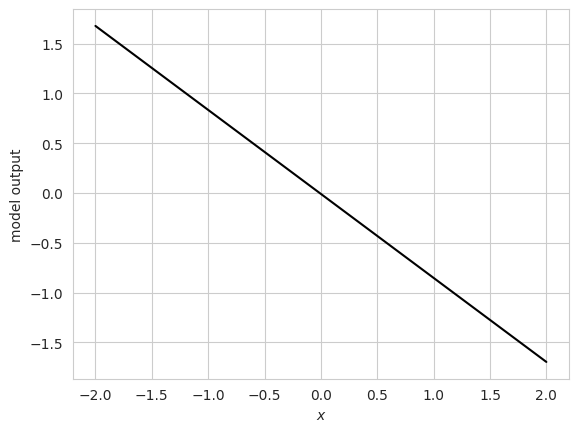

In [ ]:
import torch
from torch.nn import Linear, Parameter

torch.manual_seed(1337)
lin = Linear(1, 1)

# choose a grid of input points to evaluate the model at
x_grid = torch.linspace(-2, 2, 200)[:, None]
predictions = lin(x_grid)

from matplotlib import colors, cm, pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.plot(x_grid, predictions.detach(), 'k');
plt.xlabel('$x$');
plt.ylabel('model output');

Remarks:
* Notice how I used `[:, None]` to reshape the output of linspace. This adds an extra dimension to the tensor, which was important since the linear layer expects `num_datapoints×num_input_dimensions` shaped input. Indexing in pytorch works very similarly to numpy, if you are not familiar with it, I encourage you to check out online tutorials on numpy and torch indexing.
* We evaluated the model by simply calling `lin(x_grid)`. The output has a computational graph attached, for subsequent backpropagation. In order to plot the result, we have to detach the graph, by calling the `detach` method.


## Question A.1: Reparametrization


We will now create an equivalent model to our favourite `lin`. One that uses a different parametrization, but is still a linear model. Our original linear model is described as follows:

$$
f(x ; w_1, b_1) = w_1x + b_1
$$

Now, we will consider a slightly different, but equivalent model:

$$
g(x; w_2, b_2) = c \cdot w_2 x + b_2,
$$

where $c\neq0$ is a constant (not a trainable parameter). One can see that by setting $w_2 = \frac{w_1}{c}$ and $b_2 = b_1$, the two models implement the same linear function.

Your task is to create a function that takes a linear layer that implements $f$, and outputs another pytorch model that implements $g$, setting $g$'s parameters $w_2, b_2$ so that at creation, the two models give the same output.

Tips:
* if/when copying layers, use `deepcopy` to ensure that you don't accidentally tie the parameters of the new layer and the original together.
* you can use a `torch.nn.Sequential` to compose layers. This task is easiest to solve by creating new network with two `Linear` layers.
* make sure the new model has only two trainable parameters (i.e. $c$ does not end up a trainable parameter). You can make a parameter fixed by setting `param.requires_grad=False`.
* you can use `lin.weight` and `lin.bias`
* when manipulating model weights directly, I suggest using `torch.no_grad`

### Answer A.1

Please complete the code blocks below.

In [ ]:
from copy import deepcopy

@torch.no_grad()
def reparametrise_linear(linear_layer, c=2.0):
    """Takes a Linear pytorch layer, and returns an equivalent network."""

    layer_copy = deepcopy(linear_layer)
    layer_copy.weight /= c
    layer_copy.bias /= c  # this is required if layer_mult_c is applied after

    layer_mult_c = Linear(layer_copy.out_features, layer_copy.out_features, bias=False)
    layer_mult_c.weight = Parameter(c*torch.eye(layer_copy.out_features), requires_grad=False)

    return torch.nn.Sequential(layer_copy, layer_mult_c)

In [ ]:
#here is a simple test that should successfully run
torch.manual_seed(1337)
model = Linear(1, 1)
model2 = reparametrise_linear(model, c=2.0)
assert torch.allclose(model(x_grid), model2(x_grid))

assert len([p for p in model.parameters() if p.requires_grad])==2
assert len([p for p in model2.parameters() if p.requires_grad])==2

## Question A.2: Plot the effect of a single gradient step



Your second task is to illustrate how a single gradient descent step changes our model's output, after we observe a single datapoint at $x=1, y=1$.

#### A.2.1.
Please fill out each of the incomplete lines commented as '## step n' below.
* For optimizer, please use SGD, no momentum, learning rate set to $0.05$
* for loss, please calculate (mean) squared error between the model's output at $x$ and the desired output $y$.

Use the `reparametrize_linear` the model from the previous task to create equivalent linear models, repeat the single gradient step experiment on each.

#### A.2.2.
Plot the results, and explain any differences between the reparametrised and original models' behaviour in the text box below.

####A.2.3.
Can you derive the effect of the gradient step analytically? You can use LaTeX to type it up if you'd like.

### Answer A.2

Please complete the code cells and add interpretation in the text cell below.

In [ ]:
#note: if you import things for this cell, please do that here
from torch.optim import SGD
from torch.nn.functional import mse_loss

#here is the single training datapoint
x = torch.tensor([[1.0]])
y = torch.tensor([[1.0]])

def gradient_steps(model, x, y, x_test, lr, iterations):
    """Performs the specified amount of SGD optimization steps on a model."""

    ##step 1: compute the prediction of the model on x_test before the step
    pred_before = model(x_test)
    preds_all = [pred_before.detach()]

    ## step 2: create an SGD optimizer
    optimizer = SGD(model.parameters(), lr=lr)

    ## step 3: calculate the squared loss
    loss = torch.nn.MSELoss()

    for i in range(iterations):
        optimizer.zero_grad()
        loss(model(x), y).backward()  ## step 4: backpropagate
        optimizer.step()  ## step 5: take a step with the optimizer
        preds_all.append(model(x_test).detach())  ## step 6: calculate the predictions after the step


    return preds_all

def single_gradient_step(model, x, y, x_test=x_grid, lr=0.05):
    return gradient_steps(model, x, y, x_test, lr, iterations=1)

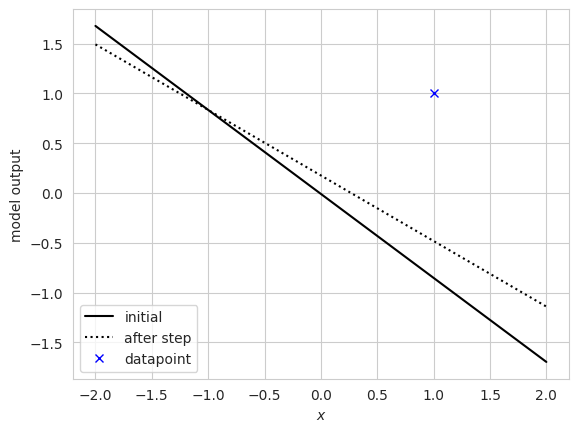

In [ ]:
torch.manual_seed(1337)
lin = Linear(1, 1)
pred_before, pred_after = single_gradient_step(lin, x, y)
plt.plot(x_grid, pred_before, 'k')
plt.plot(x_grid, pred_after, 'k:')
plt.plot(x, y, 'bx')
plt.legend(['initial', 'after step','datapoint'], loc=3)
plt.xlabel('$x$'); plt.ylabel('model output');

#### Interpretation

please add your interpretation of findings (2-3 sentences)

## Question A.3: Where does training converge?



Using the `reparametrise_linear` function below, create new versions of the `lin` model, with $c=2$ and $c=0.5$, respectively. Now, train each of these models on the $x=1, y=1$ datapoint using 1000 iterations of gradient descent with a learning rate of $0.01$.

Plot the solutions found, and explain what you see.

### Answer A.3

Please complete the code block below and add interpretation to the text cell.

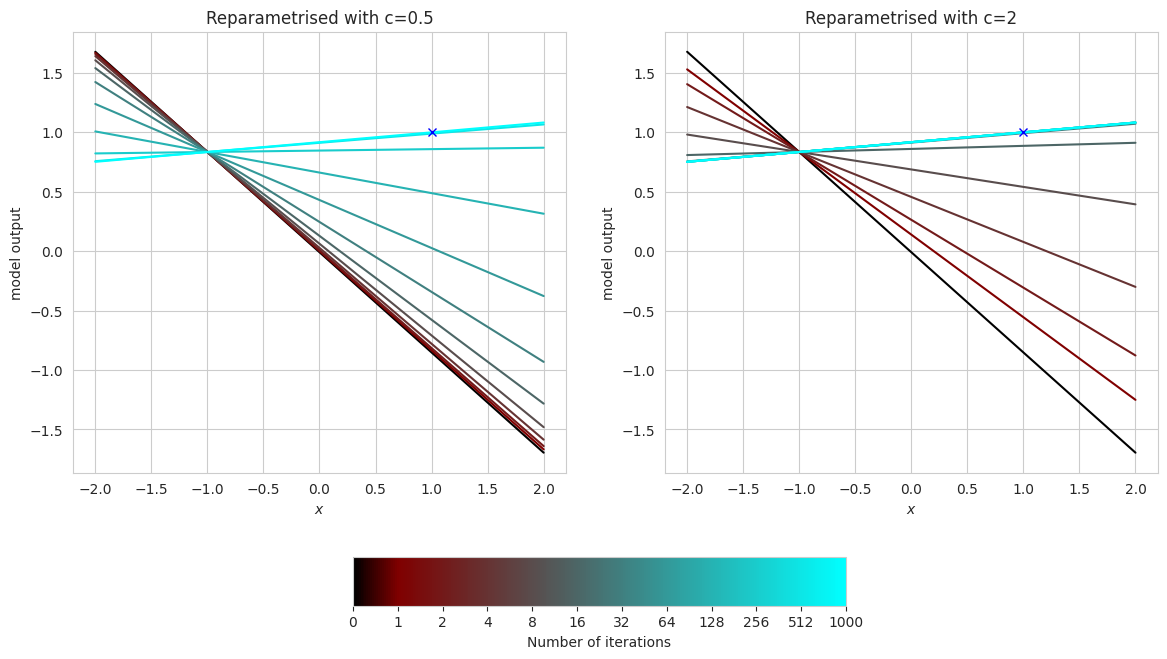

In [ ]:
torch.manual_seed(1337)
lin = Linear(1, 1)

x = torch.tensor([[1.0]])
y = torch.tensor([[1.0]])

reparam1 = reparametrise_linear(lin, c=2)
results1 = gradient_steps(reparam1, x, y, x_grid, lr=0.01, iterations=1024)
print("\n")
reparam2 = reparametrise_linear(lin, c=0.5)
results2 = gradient_steps(reparam2, x, y, x_grid, lr=0.01, iterations=1024)

fig, ((ax2, ax1), (colorbarAxis, _)) = plt.subplots(2, 2, figsize=(14, 7), height_ratios=(0.9, 0.1))
_.set_axis_off()

color_mapping = lambda i: (0.5 - i/20, i/10, i/10)
ax1.plot(x_grid, results1[0], color=(0, 0, 0))
ax2.plot(x_grid, results2[0], color=(0, 0, 0))
for i in range(11):
    ax1.plot(x_grid, results1[min(1000, 2**i)], color=color_mapping(i))
    ax2.plot(x_grid, results2[min(1000, 2**i)], color=color_mapping(i))

for ax, c in (ax1, 2), (ax2, 0.5):
    ax.set_xlabel('$x$')
    ax.set_ylabel('model output')
    ax.plot(x, y, 'bx')
    ax.set_title(f"Reparametrised with c={c}")

colorbar = plt.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1),
        cmap=colors.LinearSegmentedColormap.from_list("", [(0, 0, 0)] + [color_mapping(i) for i in range(11)])),
    pad=5, shrink=0.1, cax=colorbarAxis, orientation="horizontal"
)
colorbar.set_ticks(ticks=[x/11 for x in range(12)], labels=[0]+[2**i for i in range(10)]+[1000])
colorbar.set_label("Number of iterations")

LL, BB, WW, HH = colorbar.ax.get_position().bounds
colorbar.ax.set_position([LL+0.2, BB-0.05, WW, HH])

#### Interpretation

please add your interpretation of findings (2-3 sentences)

*note to self: maybe explain the x=-1 thing?*

## Question A.4: Reparametrization invariance in ReLU Networks




Implement a function that takes a one hidden layer ReLU network (i.e. two Linear layers with a ReLU sandwiched between them) and finds an equivalent network with different parameters that implements the same function. You can do this along the lines of [(Dinh et al, 2017)](https://arxiv.org/pdf/1703.04933.pdf).

The key observation is that the ReLU activation function satisfies $\phi(\alpha t) = \alpha \phi(t)$ for all $\alpha \neq 0$, a property called homogeneity. Thus, if we divide the weights and biases **before** the ReLU by $\alpha$, and multiply the weights after the ReLU by the same $\alpha$, overall, the network's behaviour has not changed.

Implement the `reparametrise_relu` function below. Don't forget to use `deepcopy` and `no_grad`. in multi-layer models you can use `model[i]` indexing to access the `i`-th layer. I include a basic test cell below.


### Answer A.4

Please complete the code block below.

In [ ]:
from copy import deepcopy

@torch.no_grad()
def reparametrise_relu(model, alpha=2.0):
    """Reparametrises a one-hidden-layer ReLU network using the scaling method of (Dinh et al, 2017)"""
    ## step 1: copy model
    model = deepcopy(model)   # now we can't accidentally mutate the non-local one

    ## step 2: scale weights and biases in the two linear layers
    model[0].weight *= alpha
    model[0].bias *= alpha
    model[2].weight /= alpha

    return model

In [ ]:
from torch.nn import ReLU, Sequential, Linear
#here is a simple test that should successfully run
torch.manual_seed(1337)
model = Sequential(Linear(1, 128), ReLU(), Linear(128, 1))
model2 = reparametrise_relu(model, alpha=2.0)
#the model should be functionally the same
assert torch.allclose(model(x_grid), model2(x_grid))
#both models should have 4 trainable parameters
assert len([p for p in model.parameters() if p.requires_grad])==4
assert len([p for p in model2.parameters() if p.requires_grad])==4

## Question A.5: Training from different initialization



A.5.1
Now create a two-layer ReLU network with 512 hidden units. Use the `reparametrise_relu` function, with $\alpha=10$, to find a functionally equivalent network. Starting from these two networks as initialization, train the networks until convergence on the new toy data provided. Interpret and explain the results (3-5 sentences).

A.5.2
Now explore the same using different optimizers. Do you see any difference in the results? (3-5 sentences) Could there exist an optimization algorithm which makes the two models converge to the same solution? (2-3 sentences)

### Answer A.5

Please complete the code cell below and add interpretation in the text cell provided.

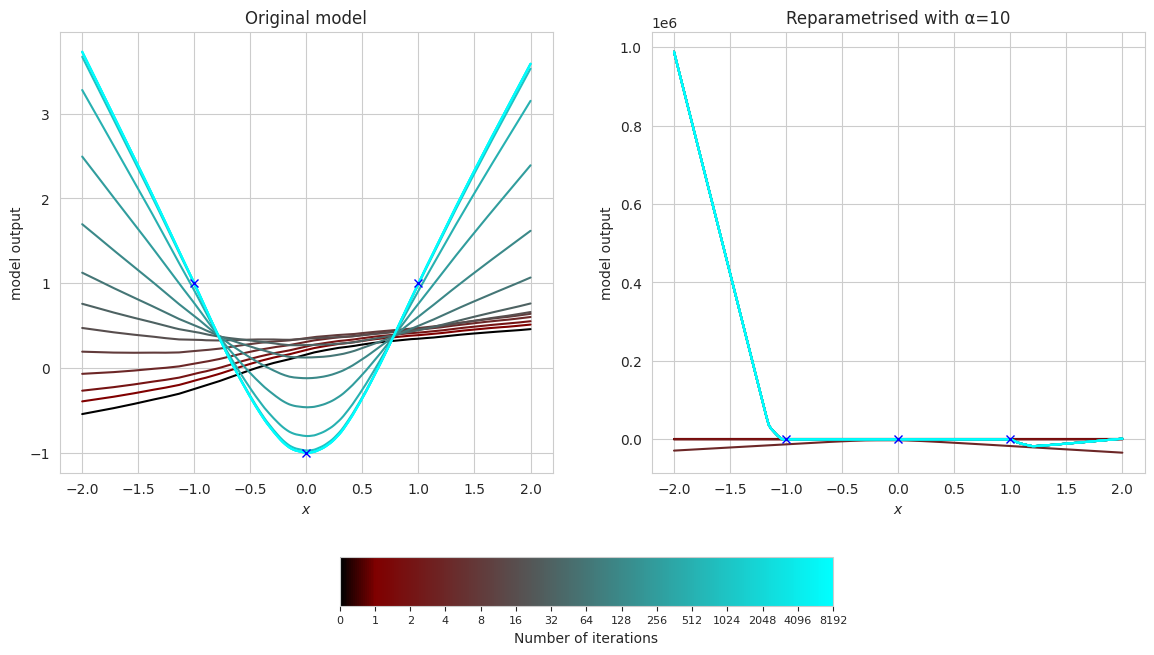

In [ ]:
from torch.nn import ReLU, Sequential, Linear
torch.manual_seed(1337)

x = torch.tensor([[-1.0], [-0.0], [1.0]])
y = torch.tensor([[1.0], [-1.0], [1.0]])

model = Sequential(Linear(1, 512), ReLU(), Linear(512, 1))

# create a reparametrized model starting from this model
reparam_model = reparametrise_relu(model, alpha=10)

# train both models until convergence (find good learning rate); plot the solution each model converged to
resultsOriginal = gradient_steps(model, x, y, x_grid, lr=0.001, iterations=2**13)
resultsReparam = gradient_steps(reparam_model, x, y, x_grid, lr=0.001, iterations=2**13)

def draw_results(resultsOriginal, resultsReparam): # (I just made this into a function to avoid copying code for the next cell)
    fig, ((ax1, ax2), (colorbarAxis, _)) = plt.subplots(2, 2, figsize=(14, 7), height_ratios=(0.9, 0.1))
    _.set_axis_off()

    color_mapping = lambda i: (0.5 - i/26, i/13, i/13)
    ax1.plot(x_grid, resultsOriginal[0], color=(0, 0, 0))
    ax2.plot(x_grid, resultsReparam[0], color=(0, 0, 0))
    for i in range(14):
        ax1.plot(x_grid, resultsOriginal[2**i], color=color_mapping(i))
        ax2.plot(x_grid, resultsReparam[2**i], color=color_mapping(i))

    ax1.set_title(f"Original model")
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('model output')
    ax1.plot(x, y, 'bx')

    ax2.set_title(f"Reparametrised with α=10")
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('model output')
    ax2.plot(x, y, 'bx')

    colorbar = plt.colorbar(
        cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1),
            cmap=colors.LinearSegmentedColormap.from_list("", [(0, 0, 0)] + [color_mapping(i) for i in range(14)])),
        pad=5, cax=colorbarAxis, orientation="horizontal"
    )
    colorbar.set_ticks(ticks=[x/14 for x in range(15)], labels=[0]+[2**i for i in range(14)])
    colorbarAxis.tick_params(labelsize=8)
    colorbar.set_label("Number of iterations")

    LL, BB, WW, HH = colorbar.ax.get_position().bounds
    colorbar.ax.set_position([LL+0.2, BB-0.05, WW, HH])


draw_results(resultsOriginal, resultsReparam)

Very different, but the one on the right still *does* converge, but its left-tail is insane (the y-axis is in $10^6$), and the loss at the training points is also much worse (though it's hard to tell from this graph alone). So even though it's not *divergence*, it might be shooting past the global optimum then getting stuck in a local optimum. So I experimented with lowering the learning rate for the reparametrised model, and:

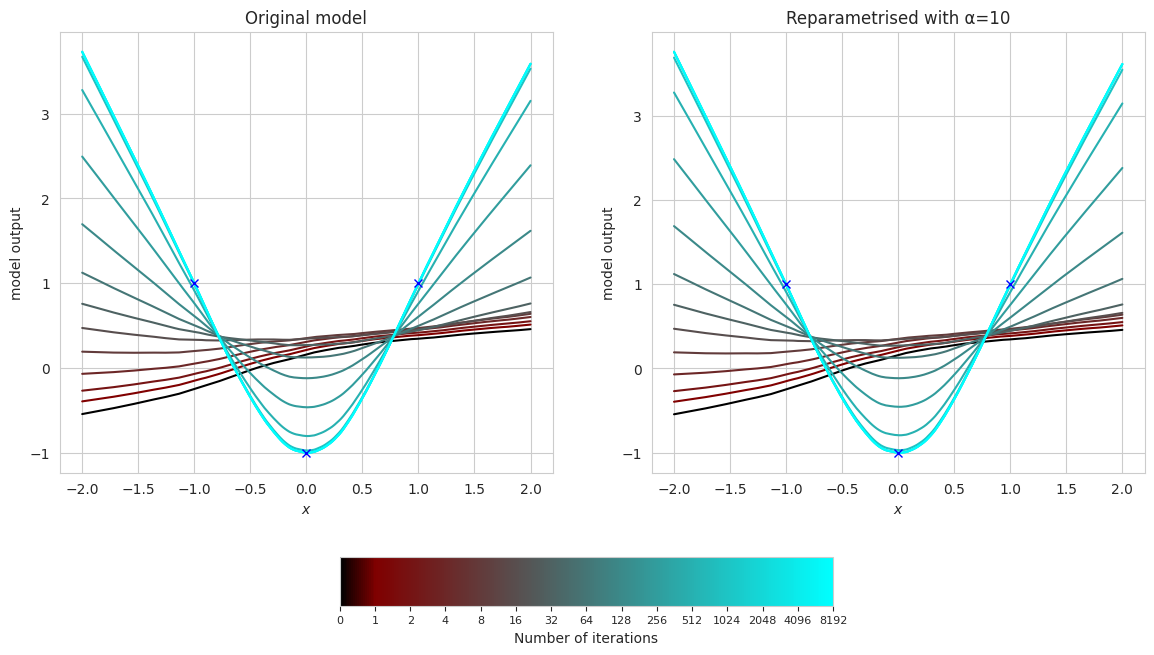

In [ ]:
torch.manual_seed(1337)
model = Sequential(Linear(1, 512), ReLU(), Linear(512, 1))
reparam_model = reparametrise_relu(model, alpha=10)

resultsOriginal = gradient_steps(model, x, y, x_grid, lr=0.001, iterations=2**13)
resultsReparam = gradient_steps(reparam_model, x, y, x_grid, lr=0.00001, iterations=2**13)

draw_results(resultsOriginal, resultsReparam)

Dividing the learning rate by 100 seems *exactly* right. This might suggest that reparametrising with 𝛂 multiplies the learning rate by 𝛂^2!

#### Interpretation

please add your interpretation of findings



## Revisiting the take-aways

Hopefully, if you followed along this exercise, you gained some fresh insights into gradient-based learning and neural networks. Please take a moment to think about the take-home messages from this exercise, and see if you can back these up with your findings from the work above:

1. In neural networks, the same function can be represented by several different settings of the parameters. This is called reparametrization-invariance.
2. Differently parametrized neural networks behave differently under gradient descent, and this difference may lead to qualitatively different solutions.
3. Initialization of parameters is crucially important. Starting from different initialization (even if it's starting from the same function) can lead to qualitatively different solutions, too.

## Section A Writeup checklist

Please compile your findings into a writeup. Please make sure you include:
* 1 figure with the linear models with legends
* summary paragraph describing the linear model findings
* derivation of gradient descent behaviour in linear model (using an extra page is allowed)
* 1 figure with the ReLU results with legends
* a qualitative description of the ReLU findings
* an explanation/interpretation of why we see what we see
* a comment on different optimizers

# B: Sawtooth network




This part of the assignment looks at the *sawtooth* network Ferenc showed in the second lecture to demonstrate that deep ReLU networks can represent exponentially complex piecewise linear functions. The function is defined by the following recursion:

\begin{align}
f_l(x) &= 2\cdot \vert f_{l-1}(x)\vert - 2\\
f_0(x) &= x
\end{align}

This function can be implemented as a deep, narrow neural network with just two ReLU units at each layer. Below, I provide a simple `pytorch` implementation. The network has three different layers in it: the input layer, the middle layers, which are repeated, and the output layer. ReLU nonlinearities are sandwiched between them.

In [ ]:
from torch.nn import Identity, Sequential, Linear, ReLU

def sawtooth_input_layer():
  '''Input layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(1, 2, bias=False)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[1], [-1]])
  return layer

def sawtooth_middle_layer():
  '''Middle layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer

def sawtooth_output_layer():
  '''Output layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 1)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2]])
    layer.bias.data = torch.Tensor([-2])
  return layer

def get_sawtooth_network(num_hidden_layers = 5, middle_layer = sawtooth_middle_layer):
  '''Returns a nn.Sequential model with ReLU activations and weights fixed to
  implement the sawtooth function.

  Parameters
  ----------
  num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
  middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
  '''
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')
  elif num_hidden_layers == 0:
    blocks = [Identity]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer())
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)

Let's look at the output of this neural network on a grid of input points:

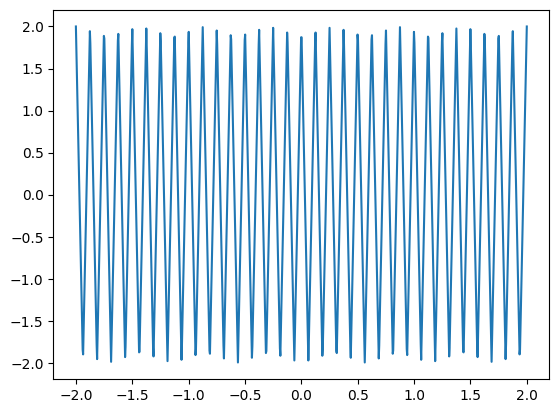

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]

model = get_sawtooth_network(6)

plt.plot(x, model(x).detach());

The sawtooth network was deliberately constructed to show that exponentially complex networks can be represented by even very simple deep network architectures like this. But are these complex outputs typical? How easy is it to break this exponential complexity property of the sawtooth networks? The assignment question below asks you to explore this a bit.

## Question B.1 Stripping the Saw's Teeth


I implemented `get_sawtooth_network` in such a way that it is possible to pass a custom functions for constructing the *middle* layers of the network. Create two new versions of this middle layer constructor in the code blocks below:
1. `noisy_sawtooth_middle_layer` should initialize the weights with a bit of random perturbation around the original fixed weights of the sawtooth network. The magnitude of the perturbation is controlled by an argument `noise_level`
2. `random_init_middle_layer` should initialize the weights completely randomly.
Create new models using these randomized layers and plot the model's output like above. I have included code blocks for plotting for convenience. Describe what you find. Is the number of linear segments still exponential?

Finally try reinitializing the whole model weights using standard initialization scheme. *Tip:* Use the `reset_parameters` function on each `Linear` layer in the model.

Please add a summary to the text cell below.

### Answer B.1

Please complete the code cells below and add your interpretation to the text cell provided.

In [ ]:
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer(noise_level = 0.1):
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]]) + torch.empty(2, 2).normal_(0, noise_level)  # Gaussian noise with
    layer.bias.data = torch.Tensor([-2, 2]) + torch.empty(2).normal_(0, noise_level)                  # StdDev = noise_level
  return layer

In [ ]:
# Modify the function below so it returns a layer with randomly initialized
# weights and biases.

def random_init_middle_layer():
  '''A randomly initialized 2x2 linear layer.'''
  return Linear(2, 2)   # This randomises with Uniform(-1/sqrt(2),  1/sqrt(2))

def gaussian_init_middle_layer():
  '''A randomly initialized 2x2 linear layer. Randomised with a wide Gaussian with zero mean.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.empty(2, 2).normal_(0, 10)   # Only Gaussian noise;
    layer.bias.data = torch.empty(2).normal_(0, 10)        # Mean=0, StdDev=10
  return layer

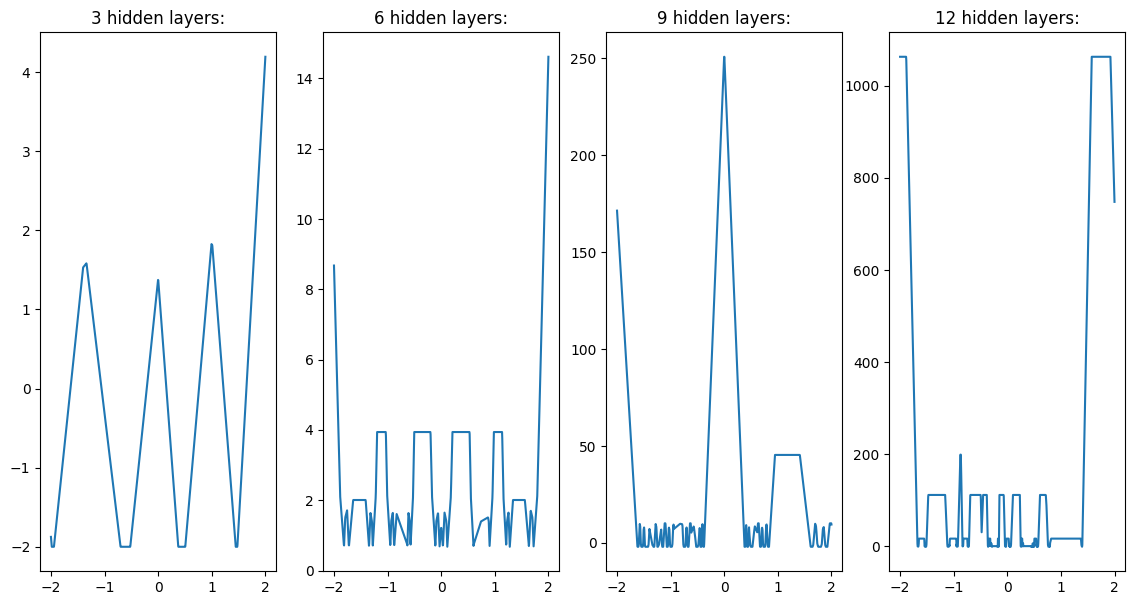

In [ ]:
# We added this plotting cell for convenience, you may build on these to
# explore what the functions you implemented do
from functools import partial

models = [get_sawtooth_network(num_hidden_layers=n, middle_layer=partial(noisy_sawtooth_middle_layer, noise_level=0.4)) for n in (3, 6, 9, 12)]

fig, axs = plt.subplots(ncols=4, figsize=(14, 7))

for n, model, ax in zip([3, 6, 9, 12], models, axs):
    ax.plot(x, model(x).detach())
    ax.set_title(f"{n} hidden layers:")

It seems like the amount of linear segments still increases with the amount of layers, but less so than before (i.e. sub-exponentially).
(though it's not always obvious how many linear segments there are, given the noise)

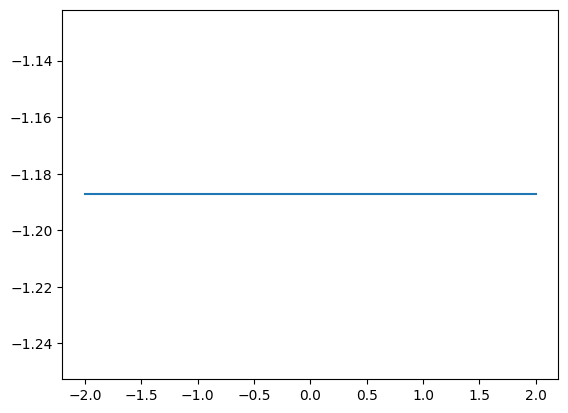

In [ ]:
from functools import partial

model = get_sawtooth_network(num_hidden_layers=5, middle_layer=partial(random_init_middle_layer))

plt.plot(x, model(x).detach())

#### Interpretation

Please summarise your findings (2-3 sentences).

## Question B.2: Shallow Sawtooth Network

Previously, the sawtooth function was implemented with a deep, narrow neural network, now try implementing it with a wide network using only 3 layers. Hint: See Appeindix C here (https://arxiv.org/pdf/1611.03530.pdf).

Repeat the analysis in the previous question and compare the results.


###(for deletion)

$$\\[0.5in]
\text{Note that if }~ -2+2(\text{RELU}(x) + \text{RELU}(-x)) > 0: \\
~~~~~~~~~~ l_1 = \begin{bmatrix} -2+2(\text{RELU}(x) + \text{RELU}(-x)) \\ 0 \end{bmatrix}; \\
\text{Otherwise:}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \\
~~~~~~~~~~ l_1 = \begin{bmatrix} 0 \\ +2-2(\text{RELU}(x) + \text{RELU}(-x)) \end{bmatrix}.$$



Intuition for this:
*   innermost bit: "how far from (whichever is closer of) -1 or 1"
*   next innermost: "how far from (the closest of) {-1.5, -0.5, 0.5, 1.5}"
*   next: "how far from (the closest of) {-1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75}


###maths

Previously, we had

$$l_0 = \begin{bmatrix}
\text{RELU}(x) \\
\text{RELU}(-x)
\end{bmatrix}.
\\[0.5in]
\text{Notice that the sum of } l_0\text{'s elements} = |x|
\\ \text{So } ~ \begin{bmatrix} 2 \\ 2 \end{bmatrix} \cdot l_0 = 2|x|
\\[0.5in]
l_1 =
\begin{bmatrix}
\text{RELU}[-2+2(\text{RELU}(x) + \text{RELU}(-x))] \\
\text{RELU}[+2-2(\text{RELU}(x) + \text{RELU}(-x))]
\end{bmatrix}
\\[0.5in]
\text{So this is equivalent to } \\
\begin{bmatrix}
\text{if } |x|<1 \text{ then } 0 \text{ else }  -2+2(\text{RELU}(x) + \text{RELU}(-x)) \\
\text{if } |x|>1 \text{ then } 0 \text{ else }  +2-2(\text{RELU}(x) + \text{RELU}(-x))
\end{bmatrix}
\\[0.5in]
= \begin{bmatrix}
\text{if } |x|<1 \text{ then } 0 \text{ else }  -2+\text{RELU}(2x) + \text{RELU}(-2x) \\
\text{if } |x|>1 \text{ then } 0 \text{ else }  +2-\text{RELU}(2x) - \text{RELU}(-2x)
\end{bmatrix}
\\[0.5in]
\text{Let } v_1=\begin{bmatrix} 1 \\ 1 \end{bmatrix} \cdot l_1
\\ \text{(this is the only thing from } l_1 \text{ that we care about; note that } v \text{ is non-negative)}
\\[0.5in]
\text{If we expand the remaining RELUs the same way, we see that:}
\\ -2≤x<-1 ~\implies v = -2 - 2x
\\ -1≤x<~0 ~~~\implies v = +2 + 2x
\\ ~~~~0≤x<~1 ~~~\implies v = +2 - 2x
\\ ~~~~1≤x<~2 ~~~\implies v = -2 + 2x
\\[0.3in]
\text{So now } l_2 = \begin{bmatrix} \text{RELU}(-2 + 2v) \\ \text{RELU}(+2 - 2v) \end{bmatrix}, \text{ and } v_2=\begin{bmatrix} 1 \\ 1 \end{bmatrix} \cdot l_2
\\[0.3in] -2≤x<-1 ~\implies v_2 = |-2 + 2(-2 - 2x)| = |-6 -4x|
\\ -1≤x<~0 ~~~\implies v_2 = |-2 + 2(+2 + 2x)| = |+2 + 4x|
\\ ~~~~0≤x<~1 ~~~\implies v_2 = |-2 + 2(+2 - 2x)| = |+2 - 4x|
\\ ~~~~1≤x<~2 ~~~\implies v_2 = |-2 + 2(-2 + 2x)| = |-6 + 4x|
$$

What about a 4-size version?

$$l_0 = \begin{bmatrix}
\text{RELU}(+x+1) \\
\text{RELU}(-x-1) \\
\text{RELU}(+x-1) \\
\text{RELU}(-x+1)
\end{bmatrix}
\\[0.8in]
W = \begin{bmatrix}
1 & 1 & 0 & 0 \\
-1 & -1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & -1 & -1
\end{bmatrix},
~~~ B =
\begin{bmatrix}
-1 \\
1 \\
-1 \\
1
\end{bmatrix}
\\[0.8in]
l_1 = \begin{bmatrix}
\text{RELU}(+|x+1|-1) \\
\text{RELU}(-|x+1|+1) \\
\text{RELU}(+|x-1|-1) \\
\text{RELU}(-|x-1|+1)
\end{bmatrix}
\\[0.5in]
$$

### Answer B.2

Please write your code here.

In [ ]:
def sawtooth_input_layer():
  '''Input layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(1, 10, bias=False)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[1], [-1]] * 5)
  return layer

def sawtooth_middle_layer_wide():
  '''Middle layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(10, 10)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2]*10, [-2]*10])
    layer.bias.data = torch.Tensor([-2, 2]*5)
  return layer

def sawtooth_output_layer_wide():
  '''Output layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(10, 1)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2]])
    layer.bias.data = torch.Tensor([-2])
  return layer

def get_sawtooth_network_wide(num_hidden_layers=3, middle_layer=sawtooth_middle_layer_wide):
  '''Returns a nn.Sequential model with ReLU activations and weights fixed to
  implement the sawtooth function.

  Parameters
  ----------
  num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
  middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
  '''
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')
  elif num_hidden_layers == 0:
    blocks = [Identity]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer())
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)

#### Interpretation

Please summarise your findings (2-3 sentences).

### Section B Writeup Checklist

Please compile your findings into a writeup. Please make sure you include:
* 1 figure showing the clean and noisy sawtooth function with deep implementation (may use subfigures so long as it's legible)
* 1 figure showing the clean and noisy shawtooth function with shallow implementation (may use subfigures so long as it's legible)
* summary paragraph describing the experimental setup for the noisy analyses (how you added noise and how much)
* qualitative observations about findings
* comparing deep to shallow implementation
* drawing conclusions beyond the sawtooth example.

#C: Inductive Bias of ReLU networks



In this exercise we ask you to run your own experiment that demonstrates/reproduces some known inductive biases of neural networks.

Examples are:
* **bias towards low-complexity boolean functions** As first demonstrated by [Vallé-Perez et al, 2018](https://arxiv.org/abs/1805.08522) randomly initialised neural networks (whose inputs and outputs are binary) have a tendency to implement lower complexity Boolean functions. **Hint:** Instead of using Lempel-Ziv complexity like in the paper, you may find it easier and/or more interesting to choose other measures of complexity, such as those mentioned in [this video](https://www.youtube.com/watch?v=XAhvVn1seUY).
* **bias towards low-rank representations:** Look at, for example, Figures 1 or 2 of ([Huh et al, 2023](https://openreview.net/pdf?id=bCiNWDmlY2)). **Hint:** Training results from Figure 1 may be difficult to produce as you want to make sure you tune the learning rates for all depth/rank combinations. The rank analysis at initialization found in Figure 2. would take significantly less time to run.
* **spline behaviour:** It has been shown ([Williams et al. 2020](https://proceedings.neurips.cc/paper_files/paper/2019/file/1f6419b1cbe79c71410cb320fc094775-Paper.pdf)) that - subject to some assumtions - gradient descent training dynamics in shallow ReLU networks leads to either cubic splines (in the so called kernel regime) or linear splines (in the so called adaptive regime). The difference between the two regimes is the scale of the random initialization. for details. **Hint:** It is not expected that you follow any details of the theoretical arguments in the paper linked above. It is fine for your investigation to be purely empirical: can you find an example where a trained ReLU network closely matches a cubic spline? Can you change the behaviour by changing initialization scale or learning rates?

## Section C Writeup Checklist

This is an exploratory project, but here is an example of what components you want to include:
* a hypothesis: what is the motivation for your work, what do you expect to see or demonstrate.
* brief description of methodology, network/optimization parameters, etc
* a figure or two summarising your findings
* discussion of whether findings support your hypothesis or not, perhaps speculation or explanation about what is going on.

Note: if you run your experiments and they don't produce the expected effect, that is perfectly fine, so long as your experiment made sense. Our existing understanding of inductive biases is far from complete, and the observations above may not universal for all architectures and training regimes.